# Data Preparation for Random Forest

**Three phases of Training Data Preparation:**

1. Ship Data and Corrections
2. Float Data and Corrections
3. Merge Ship/Data Dataset for Training
3. Glider Data Preparation for Prediction


- These variables will be saved and imported into sogos_overview, in which we split the training dataset and compare three models

### Import

In [1]:
# added to environment (except pyco2) 
# run the line: <conda env update -f environment.yml>

# pip install xgboost
# !pip install cmocean
# !pip install glidertools
# !pip install pygam
# !pip install hyperopt
# !pip install dataframe_image
# !pip install gsw
!pip install PyCO2SYS 

^C
ERROR: Operation cancelled by user


In [1]:
# Import Packages

#Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning/Statistics Packages
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# import xgboost as xgb
# from pygam import LinearGAM, l, s, f

# Utility Packages
import random as rand
import os
import math
import dataframe_image as dfi
import itertools
from scipy import interpolate

# Oceanography Packages
import gsw
import PyCO2SYS as pyco2

import sogos_module as sg

In [2]:
# Set up directories
data_path = '../data/'
var_path = '../gridded-vars/'

float_directory = data_path + 'float/'
ship_filepath =  data_path + 'bottle_data.csv'

# Song local
# float_directory = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/data/float/'
# ship_filepath = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/data/ship/bottle_data.csv'

## 1. Ship Data and Corrections

- Ship Bottle Data from GO-SHIP I06 Cruise (2019)
- [Ship Data Link](https://uwnetid-my.sharepoint.com/:f:/g/personal/sangsong_uw_edu/ErLtPwS6pdZClgo0Flp9lq8BoNBWNN6mE2LJuJJVmt874A?e=qHB9qp)

In [52]:
# Load Ship Data (Already QC Filtered) into Pandas Dataframe
ship_DF = pd.read_csv(ship_filepath)

ship_DF["Julian Day"] = pd.to_datetime(ship_DF["Julian Day"].values/1440, unit='D', origin=pd.Timestamp('1980-01-01'))
ship_DF['Yearday'] = sg.datetime2ytd(ship_DF['Julian Day'])


In [53]:
# Add CT and SA to ship_DF
ship_DF["SA"] = gsw.SA_from_SP(ship_DF["Salinity"], ship_DF["Pressure"], ship_DF["Longitude"], ship_DF["Latitude"])
ship_DF["CT"] = gsw.CT_from_t(ship_DF["SA"], ship_DF["Temperature"], ship_DF["Pressure"])
# See note for pH correction below
ship_DF = ship_DF.rename(columns={'pH':'pH_lab'})

In [54]:
ship_DF.Temperature

0        0.7214
1        0.7200
2        0.7193
3        0.7221
4        0.4779
         ...   
1817    20.1644
1818    20.1626
1819    20.1614
1820    20.1627
1821    20.1897
Name: Temperature, Length: 1822, dtype: float64

***pH correction***
- Note: one pH correction must be performed for the ship bottle data
- Bottle data is analyzed in lab conditions (25 degC, 0 atm)
- Rest of ship measurements are in-situ, so we transform the variables to the appropriate environmental temp/pressure using the PyCO2Sys package

In [5]:
## Bottle pH Corrections --  ~1min runtime
pH_situ = []
for i in range(len(ship_DF)):
    # lab conditions
    pressure = 0            
    temperature = 25

    # convert to ship in-situ conditions
    try:
        result = pyco2.sys(par1 = ship_DF["Alkalinity"][i],
                           par1_type = 1,
                           par2 = ship_DF["pH_lab"][i],
                           par2_type = 3,
                           opt_pH_scale = 1,
                           salinity = ship_DF["SA"][i],
                           temperature = temperature,
                           temperature_out = ship_DF["CT"][i],
                           pressure = pressure,
                           pressure_out = ship_DF["Pressure"][i]
                          )
        pH_out = result["pH_out"]
    except SyntaxError: pH_out = np.nan
    pH_situ.append(pH_out)
pH_situ
ship_DF['pH']= pH_situ

In [6]:
ship_DF.head()

,Latitude,Longitude,Julian Day,Bottle Depth,Pressure,Temperature,Salinity,Oxygen,Nitrate,DIC,Alkalinity,pH_lab,Yearday,SA,CT,pH
0,-68.3422,31.535,2019-04-16 09:07:00,524,522.0,0.7214,34.6535,210.8,32.03,2252.1,2348.73,7.5811,105.379861,34.824140,0.698461,7.938548
1,-68.3422,31.535,2019-04-16 09:07:00,524,505.4,0.7200,34.6525,211.0,32.02,NaN,NaN,NaN,105.379861,34.823094,0.697907,NaN
2,-68.3422,31.535,2019-04-16 09:07:00,524,490.7,0.7193,34.6523,211.0,31.94,2250.7,2346.14,7.5831,105.379861,34.822833,0.697944,7.942037
3,-68.3422,31.535,2019-04-16 09:07:00,524,439.7,0.7221,34.6491,211.1,32.01,NaN,NaN,NaN,105.379861,34.819407,0.703262,NaN
4,-68.3422,31.535,2019-04-16 09:07:00,524,388.8,0.4779,34.5828,221.2,32.09,2250.4,2339.87,7.5826,105.379861,34.752592,0.462921,7.949975


,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH
1500,128.100000,2019-05-09 02:24:00.000000000,-33.2343,28.0952,127.5,35.495458,15.362345,164.5,11.08,NaN
1501,128.100000,2019-05-09 02:24:00.000000000,-33.2343,28.0952,98.5,35.690661,18.594905,182.0,4.88,8.002609
1502,128.100000,2019-05-09 02:24:00.000000000,-33.2343,28.0952,75.5,35.614476,19.523607,169.3,5.84,7.989444
1503,128.100000,2019-05-09 02:24:00.000000000,-33.2343,28.0952,51.6,35.510259,20.913244,162.6,5.77,7.981659
1504,128.100000,2019-05-09 02:24:00.000000000,-33.2343,28.0952,31.2,35.422045,24.027048,207.4,0.11,NaN
...,...,...,...,...,...,...,...,...,...,...
1817,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,97.7,35.791053,20.119472,220.7,0.26,8.078181
1818,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,73.9,35.791240,20.122109,220.8,0.25,8.079073
1819,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,48.2,35.790599,20.125722,220.8,0.27,8.079917
1820,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,33.1,35.790590,20.129836,221.3,0.25,8.081391


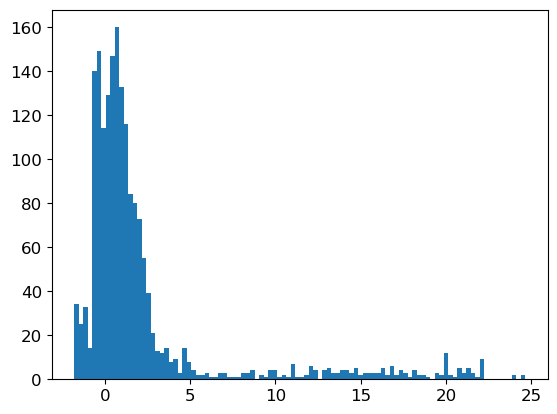

In [45]:
# ship_DF['CT'].describe()
plt.hist(ship_DF['CT'], bins=100)
ship_DF[ship_DF.CT > 15]

## 2. Float Data and Corrections

- Use all QC-ed data from the 7 Argo floats that were deployed during the GO-SHIP cruise from which the shipboard data abve comes
- [Float Data Link](https://uwnetid-my.sharepoint.com/:f:/g/personal/sangsong_uw_edu/Es-ESkVfIlpHhpFq7o5LTaoBk6IOFXMqQ8wFCgLMA512uw?e=7cWT6J)


In [24]:
floatDSdict = {}
for filename in os.listdir(float_directory):
    fp = float_directory + filename
    DS = xr.open_dataset(fp, decode_times=False)
    floatDSdict[filename[0:7]] = DS                 # pulls float ID from the filename string 

## Check float quality control
flag = 0
for floatnum in floatDSdict:
    for prof in floatDSdict[floatnum]["PARAMETER_DATA_MODE"]:
        data_modes = np.concatenate((prof.values[-2:],prof.values[0:4]))
        if np.all((data_modes == b'D') | (data_modes == b'A')) == False:
            flag = 1
if flag == 0:
    print("Data Mode is all D or A! All Good!")

Data Mode is all D or A! All Good!


In [25]:
# Create a pandas DataFrame for all float data (long - collapse!)
# From BGC-Argo Toolbox
def make_float_DF(floatDSdict):
    """
    Create a dictionary with all necesary data fields from Argo.

    # We Want the following data: 
    # Data Type, Date Update, LATITUDE, LONGITUDE, Position QC, PRES_ADJUSTED, PRES_ADJUSTED_QC,
    # TEMP_ADJUSTED, TEMP_ADJUSTED_QC, PSAL_ADJUSTED, PSAL_ADJUSTED_QC, DOXY_ADJUSTED, DOXY_ADJUSTED_QC
    # CHLA_ADJUSTED, CHLA_ADJUSTED_QC, NITRATE_ADJUSTED, NITRATE_ADJUSTED_QC

    # Data Type is structured differently so we will process the QC in a different way.
    """
    
    TrainingData = {
        # "Serial Number" : [],
        # "Data Mode": [],
        "Julian Day" : [],
        "Julian Day QC" : [],
        "Latitude" : [],
        "Longitude" : [],
        "Position QC" : [],
        "Pressure" : [],
        "Pressure QC": [],
        "Temperature Adjusted" : [],
        "Temperature Adjusted QC" : [],
        "Temperature" : [],
        "Temperature QC" : [],
        "Salinity Adjusted" : [],
        "Salinity Adjusted QC" : [],
        "Salinity" : [],
        "Salinity QC" : [],
        "Oxygen" : [],
        "Oxygen QC" : [],
        "Nitrate": [],
        "Nitrate QC": [],
        "pH": [],
        "pH QC": []
    }

    # Iterate through all floats in float dictionary
    for floatnum in floatDSdict:
        # Establish empty lists to append data to
        # float_serial = []
        # data_mode = []
        float_juld = []
        juld_QC = []
        float_lat = []
        float_lon = []
        position_QC = []
        float_pres = []
        pres_QC = []
        float_temp_adj = []
        temp_adj_QC = []
        float_temp = []
        temp_QC = []
        float_sal = []
        sal_QC = []
        float_sal_adj = []
        sal_adj_QC = []
        float_ox = []
        ox_QC = []
        nit = []
        nit_QC = []
        pH = []
        pH_QC = []
        # Iterate through every profile of a specific float
        for iprof in floatDSdict[floatnum].N_PROF.values:
            # Append Pressure, Temperature, P Salinity, Dis Oxygen, Nitrate, and pH, as well as associated QC
            float_pres = float_pres + list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)
            pres_QC = pres_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PRES_ADJUSTED_QC[iprof].values]
            float_temp_adj = float_temp_adj + list(floatDSdict[floatnum].TEMP_ADJUSTED[iprof].values)
            temp_adj_QC = temp_adj_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].TEMP_ADJUSTED_QC[iprof].values]
            float_temp = float_temp + list(floatDSdict[floatnum].TEMP[iprof].values)
            temp_QC = temp_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].TEMP_QC[iprof].values]
            float_sal_adj = float_sal_adj + list(floatDSdict[floatnum].PSAL_ADJUSTED[iprof].values)
            sal_adj_QC = sal_adj_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PSAL_ADJUSTED_QC[iprof].values]
            float_sal = float_sal + list(floatDSdict[floatnum].PSAL[iprof].values)
            sal_QC = sal_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PSAL_QC[iprof].values]
            float_ox = float_ox + list(floatDSdict[floatnum].DOXY_ADJUSTED[iprof].values)
            ox_QC = ox_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].DOXY_ADJUSTED_QC[iprof].values]
            nit = nit + list(floatDSdict[floatnum].NITRATE_ADJUSTED[iprof].values)
            nit_QC = nit_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].NITRATE_ADJUSTED_QC[iprof].values]
            pH = pH + list(floatDSdict[floatnum].PH_IN_SITU_TOTAL_ADJUSTED[iprof].values)
            pH_QC = pH_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PH_IN_SITU_TOTAL_ADJUSTED_QC[iprof].values]
            # print(float_pres)

            # Append Julian Day, lat, lon, and QC. Values stay the same for whole profile
            # float_serial_temp = np.array2string(floatDSdict[floatnum].FLOAT_SERIAL_NO[iprof].values)
            float_juld_temp = pd.to_datetime(floatDSdict[floatnum].JULD.values[iprof], unit='D', origin=pd.Timestamp('1950-01-01'))
            juld_QC_temp = int(floatDSdict[floatnum].JULD_QC.values[iprof])
            float_lat_temp = float(floatDSdict[floatnum].LATITUDE.values[iprof])
            float_lon_temp = float(floatDSdict[floatnum].LONGITUDE.values[iprof])
            position_QC_temp = int(floatDSdict[floatnum].POSITION_QC.values[iprof])
            data_mode_temp = [str(i.decode("utf-8")) for i in floatDSdict[floatnum].PARAMETER_DATA_MODE[iprof].values]
            # print(data_mode_temp)
            # print(position_QC_temp)

            # Duplicate values to be of the right array size since values stay the same for whole profile
            # float_serial = [float_serial_temp] * len(float_pres)
            float_juld = float_juld + ([float_juld_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            juld_QC = juld_QC + ([juld_QC_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            float_lat = float_lat + ([float_lat_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            float_lon = float_lon + ([float_lon_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            position_QC = position_QC + ([position_QC_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            # data_mode = data_mode + [data_mode_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values))
        print("float", floatnum, "completed")

        # Add to overall training data dictionary
        # TrainingData["Serial Number"] = TrainingData["Serial Number"] + float_serial
        # TrainingData["Data Mode"] = TrainingData["Data Mode"] + data_mode
        TrainingData["Julian Day"] = TrainingData["Julian Day"] + float_juld
        TrainingData["Julian Day QC"] = TrainingData["Julian Day QC"] + juld_QC
        TrainingData["Latitude"] = TrainingData["Latitude"] + float_lat
        TrainingData["Longitude"] = TrainingData["Longitude"] + float_lon
        TrainingData["Position QC"] = TrainingData["Position QC"] + position_QC
        TrainingData["Pressure"] = TrainingData["Pressure"] + float_pres
        TrainingData["Pressure QC"] = TrainingData["Pressure QC"] + pres_QC
        TrainingData["Temperature Adjusted"] = TrainingData["Temperature Adjusted"] + float_temp_adj
        TrainingData["Temperature Adjusted QC"] = TrainingData["Temperature Adjusted QC"] + temp_adj_QC
        TrainingData["Temperature"] = TrainingData["Temperature"] + float_temp
        TrainingData["Temperature QC"] = TrainingData["Temperature QC"] + temp_QC
        TrainingData["Salinity Adjusted"] = TrainingData["Salinity Adjusted"] + float_sal_adj
        TrainingData["Salinity Adjusted QC"] = TrainingData["Salinity Adjusted QC"] + sal_adj_QC
        TrainingData["Salinity"] = TrainingData["Salinity"] + float_sal
        TrainingData["Salinity QC"] = TrainingData["Salinity QC"] + sal_QC
        TrainingData["Oxygen"] = TrainingData["Oxygen"] + float_ox
        TrainingData["Oxygen QC"] = TrainingData["Oxygen QC"] + ox_QC
        TrainingData["Nitrate"] = TrainingData["Nitrate"] + nit
        TrainingData["Nitrate QC"] = TrainingData["Nitrate QC"] + nit_QC
        TrainingData["pH"] = TrainingData["pH"] + pH
        TrainingData["pH QC"] = TrainingData["pH QC"] + pH_QC   
    # Convert dictionary into pandas dataframe object
    TrainingDF = pd.DataFrame.from_dict(TrainingData)

    #QC for Pressure, Position, Temperature, and Salinity, Nitrate, Oxygen, pH
    # 1: Good data
    # 2: Probably good data
    # 8: Estimated
    # A: real time adjusted values
    # D: Delayed mode
    # Taken from https://argo.ucsd.edu/data/how-to-use-argo-files/

    TrainingDF = TrainingDF[(TrainingDF["Position QC"] == 1) | (TrainingDF["Position QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Julian Day QC"] == 1) | (TrainingDF["Julian Day QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Pressure QC"] == 1) | (TrainingDF["Pressure QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Temperature QC"] == 1) | (TrainingDF["Temperature QC"] == 2) | (TrainingDF["Temperature QC"] == 8)]
    TrainingDF = TrainingDF[(TrainingDF["Salinity QC"] == 1) | (TrainingDF["Salinity QC"] == 2) | (TrainingDF["Salinity QC"] == 8)]
    TrainingDF = TrainingDF[(TrainingDF["Oxygen QC"] == np.nan) | ((TrainingDF["Oxygen QC"] == 1) | (TrainingDF["Oxygen QC"] == 2))]
    TrainingDF = TrainingDF[(TrainingDF["Nitrate QC"] == 1) | (TrainingDF["Nitrate QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["pH QC"] == 1) | (TrainingDF["pH QC"] == 2)]

    # Spatial Bounds
    # TrainingDF = TrainingDF[(TrainingDF["Longitude"] < 33) & (TrainingDF["Longitude"] > 27)]

    return TrainingDF

In [26]:
# Make float DF, add SA and CT fields
float_DF = make_float_DF(floatDSdict)
float_DF["SA"] = gsw.SA_from_SP(float_DF["Salinity Adjusted"],float_DF["Pressure"],float_DF["Longitude"],float_DF["Latitude"]).values
float_DF["CT"] = gsw.CT_from_t(float_DF["Salinity Adjusted"], float_DF["Temperature Adjusted"], float_DF["Pressure"])
float_DF['Yearday'] = sg.datetime2ytd(float_DF['Julian Day'])

float 5906036 completed
float 5906030 completed
float 5906031 completed
float 5906034 completed
float 5906035 completed
float 5906033 completed
float 5906032 completed


(array([4.000e+00, 1.000e+00, 5.000e+00, 5.000e+00, 1.000e+01, 3.000e+00,
        1.700e+01, 2.900e+01, 3.100e+01, 4.800e+01, 7.800e+01, 1.520e+02,
        4.800e+02, 5.440e+02, 7.730e+02, 1.046e+03, 7.140e+02, 6.030e+02,
        6.090e+02, 4.600e+02, 4.190e+02, 3.730e+02, 3.820e+02, 3.650e+02,
        2.640e+02, 2.410e+02, 2.280e+02, 1.990e+02, 2.170e+02, 1.150e+02,
        1.400e+02, 1.610e+02, 1.850e+02, 2.250e+02, 1.770e+02, 1.430e+02,
        1.760e+02, 1.470e+02, 1.080e+02, 1.830e+02, 1.070e+02, 1.090e+02,
        1.100e+02, 1.040e+02, 1.060e+02, 1.360e+02, 1.060e+02, 1.030e+02,
        1.130e+02, 1.160e+02, 1.230e+02, 1.470e+02, 1.120e+02, 1.130e+02,
        1.060e+02, 9.000e+01, 1.100e+02, 1.200e+02, 8.200e+01, 9.900e+01,
        1.120e+02, 1.090e+02, 1.120e+02, 1.430e+02, 1.530e+02, 1.100e+02,
        9.600e+01, 1.670e+02, 1.240e+02, 1.460e+02, 2.480e+02, 1.710e+02,
        1.300e+02, 1.530e+02, 1.300e+02, 8.500e+01, 6.200e+01, 6.200e+01,
        4.700e+01, 3.600e+01, 4.100e+0

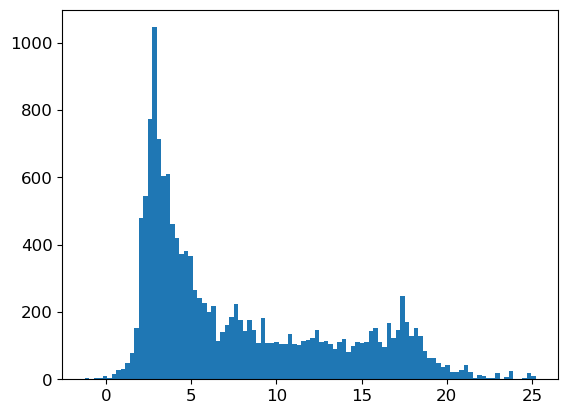

In [30]:
# float_DF['Temperature Adjusted'].describe()
plt.hist(float_DF['Temperature Adjusted'], bins=100)

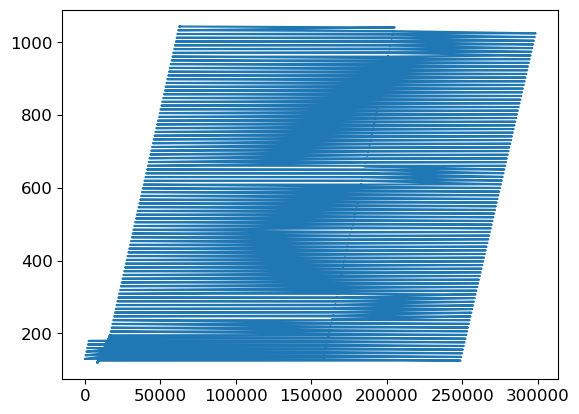

In [38]:
# float_DF[float_DF.CT>5].describe()
fdf = float_DF.sort_values('Yearday')
plt.plot(fdf.Yearday)

## 3. Merge Ship/Float Dataframe

In [10]:
## Combine float and ship data
# Reorder variables and drop lab pH from ship data
lvar = ['Yearday', 'Julian Day', 'Latitude', 'Longitude', 'Pressure', 'SA', 'CT', 'Oxygen', 'Nitrate', 'pH']
ship_DF = ship_DF[lvar] 
float_DF = float_DF[lvar]

In [11]:
# Merge datasets
total_DF = pd.concat([float_DF, ship_DF], ignore_index=True)
# Limiting pressure to 2000
total_DF = total_DF[total_DF["Pressure"] < 2000]
total_DF = total_DF.reset_index(drop = True)
total_DF.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH
0,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,7.800000,35.749064,21.245133,220.721359,-0.594459,8.070192
1,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,11.800000,35.749061,21.244360,220.629868,-0.747419,8.069442
2,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,15.800000,35.751057,21.236517,220.523651,-0.743400,8.069372
3,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,21.799999,35.760092,21.199039,220.215622,-0.763693,8.067467
4,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,25.799999,35.761097,21.181224,219.909927,-0.769277,8.066362


### Add Optional Training Fields

- Add Spice (a combined measure of Temperature and Salinity)
- Add Sigma 0 (potential density coordinate) which represents an orthogonal axis to spice

In [12]:
# Add spice
total_DF["Spice"] = gsw.spiciness0(total_DF["SA"].values, total_DF["CT"].values)

# Add sigma variables
total_DF["Sigma 0"] = gsw.sigma0(total_DF["SA"].values, total_DF["CT"].values)
# total_DF["Sigma 1"] = gsw.sigma1(total_DF["SA"].values, total_DF["CT"].values)
# total_DF["Sigma 2"] = gsw.sigma2(total_DF["SA"].values, total_DF["CT"].values)

# N^2 is at the middle of two pressure level, so the total length will not be match with other variables
# total_DF["N_Squared"],_ = gsw.stability.Nsquared(total_DF["SA"].values, total_DF["CT"].values, total_DF["Pressure"].values, lat=total_DF["Latitude"].values, axis=0)
# See solution in sogos_module under the Pchip_buoyancy function. Works on Gliders, can be modified for DF's if needed. 

In [13]:
# Last Drop NA Check
total_DF = total_DF.dropna()
total_DF = total_DF.reset_index(drop = True)
total_DF.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Spice,Sigma 0,Sigma 1,Sigma 2
0,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,7.800000,35.749064,21.245133,220.721359,-0.594459,8.070192,4.281727,24.865606,29.115498,33.272639
1,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,11.800000,35.749061,21.244360,220.629868,-0.747419,8.069442,4.281514,24.865816,29.115720,33.272872
2,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,15.800000,35.751057,21.236517,220.523651,-0.743400,8.069372,4.280874,24.869467,29.119473,33.276725
3,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,21.799999,35.760092,21.199039,220.215622,-0.763693,8.067467,4.277442,24.886532,29.137031,33.294762
4,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,25.799999,35.761097,21.181224,219.909927,-0.769277,8.066362,4.273337,24.892179,29.142934,33.300915


In [14]:
# Optional save to file
float_DF.to_csv(var_path + 'FloatData_DF.csv')
ship_DF.to_csv(var_path + 'ShipData_DF.csv')
total_DF.to_csv(var_path + 'Merged_ShipFloat_DF_1202.csv')

## 4. Glider Preparation for Training

- Need to match formatting of glider data to match that of ship/float
- Then the model (fit onto ship/float) can be run on glider tracks

In [15]:
# Import glider data
# Pressure-gridded data to 1m for each glider
gp_659 = xr.open_dataset(data_path + 'gp_659_forMLGeo1026.nc')
gp_660 = xr.open_dataset(data_path + 'gp_660_forMLGeo1026.nc')

# Isopycnal-gridded data (to .001 sigma) for each glider
gi_659 = xr.open_dataset(data_path + 'gi_659_forMLGeo1026.nc')
gi_660 = xr.open_dataset(data_path + 'gi_660_forMLGeo1026.nc')

- Note coordinates of the "gp" gridded-pressure Dataset:

                nprof: profile number for glider. 
                    Each upcast and downcast of the glider dive counts as a separate profile .
                    Dive number is stored separately as a variable

                depth: gridded to 1m, to 1000m depth

- Information on variables is in the file `Seaglider_DataGuide.pdf` in the main ml-sogos folder.
- Note two oxygen variables:

                'oxygen_raw' is uncorrected for the optode time response lag. 
                'oxygen' has been corrected using the method in Bittig (2017) and should be used
                

In [16]:
# Gridded onto pressure
print('gp coordinates are: ' + str(gp_659._coord_names))
# Gridded onto isopycnals
print('gi coordinates are: ' + str(gi_659._coord_names))

gp coordinates are: {'nprof', 'depth'}
gi coordinates are: {'sigma', 'nprof'}


In [26]:
# Note: gi grids have not been filled with attribute data.
# Attributes and variable attributes (like units, notes) could be copied over to gi (not written yet)
# Data itself is fine, but in case we want to add some meta information to the .nc file 
gi_659.oxygen   # missing some attribute data
gp_659.oxygen   # gp has all attributes like description and units

<xarray.DataArray 'oxygen' (depth: 1001, nprof: 912)>
[912912 values with dtype=float64]
Coordinates:
  * nprof    (nprof) int64 0 1 2 3 4 5 6 7 8 ... 904 905 906 907 908 909 910 911
  * depth    (depth) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999 1000
Attributes:
    description:  Time lag corrected with blthickness = 40um, threshold 0.75
    units:        umol/kg

In [41]:
gp_659

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 912)
Coordinates:
  * nprof       (nprof) int64 0 1 2 3 4 5 6 7 ... 905 906 907 908 909 910 911
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    time        (depth, nprof) datetime64[ns] 2019-04-30T13:58:31.250083328 ....
    dive        (nprof) int16 2 2 3 3 4 4 5 5 ... 459 460 460 461 461 462 462
    lat         (depth, nprof) float32 -51.5 -51.49 -51.48 ... nan nan nan
    lon         (depth, nprof) float32 30.05 30.06 30.07 30.09 ... nan nan nan
    speed       (depth, nprof) float32 ...
    P           (depth, nprof) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    SA          (depth, nprof) float32 nan 33.98 nan 33.98 ... nan nan nan nan
    CT          (depth, nprof) float32 nan 3.506 nan 3.526 ... nan nan nan nan
    oxygen_raw  (depth, nprof) float32 ...
    sigma       (depth, nprof) float64 ...
    days        (depth, nprof) float64 119.6 119.6 119.6 119.6 ... nan nan nan
    buoyancy    (depth, nprof) float64 nan 3.403e-05 nan ... nan nan nan
    oxygen      (depth, nprof) float64 nan nan nan 294.3 nan ... nan nan nan nan
    spice       (depth, nprof) float64 nan -0.5349 nan -0.5314 ... nan nan nan
Attributes:
    id:                              sg659_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    geospatial_lat_units:            degrees
    geospatial_lat_resolution:       seconds
    geospatial_lon_units:            degrees
    geospatial_lon_resolution:       seconds
    institution:                     Applied Physics Lab, University of Washi...
    license:                         These data may be redistributed and used...
    keywords_vocabulary:             NASA/GCMD Earth Science Keywords Version...
    references:                      http://data.nodc.noaa.gov/accession/0092291
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.6
    standard_name_vocabulary:        CF-1.6
    featureType:                     trajectoryProfile
    nodc_template_version:           NODC_NetCDF_Trajectory_Template_v0.9
    naming_authority:                edu.washington.apl
    creator_name:                    Luc Rainville
    creator_url:                     https://iop.apl.washington.edu
    creator_email:                   lucrain@uw.edu
    platform_id:                     SG659
    source:                          Seaglider SG659
    summary:                         SG659 SOGOS April 2019
    project:                         SOGOS April 2019
    glider:                          659
    mission:                         2
    seaglider_software_version:      66.12
    base_station_version:            3.0
    base_station_micro_version:      0
    quality_control_version:         1.12
    processing_level:                1.12
    instrument:                      aa4831 sbe41 wlbb2fl 
    title:                           Physical, chemical, and biological data ...
    keywords:                        Water Temperature, Conductivity, Salinit...
    geospatial_lon_min:              30.04640
    geospatial_lon_max:              67.79239
    geospatial_lat_min:              -53.45803
    geospatial_lat_max:              -45.64820
    time_coverage_start:             2019-04-30T13:58:31Z
    time_coverage_end:               2019-11-25T03:53:12Z
    time_coverage_duration:          P0000-00-208T13:54:40
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:29:48Z
    date_modified:                   2021-09-24T17:29:48Z
    uuid:                            0440e19e-1d5d-11ec-9be7-acde48001122

### Glider Spice Calculation

- Spice combines CT and SA information into a single variable
- Using spice is like a built-in dimensionality reduction

In [17]:
# Adding spice as a glider variable using gsw
def add_spice(gp_glider):
    spice = gsw.spiciness0(gp_glider['SA'], gp_glider['CT']) # referenced to surface 0 dbar

    # Adding spice as a variable to the glider (xarray) Dataset
    # You can only add (xarray) DataArrays to a Dataset (and not numpy arrays)
    # Anytime you need to add a new variable, you can do it in this format:
    gp_glider["spice"] = xr.DataArray(spice, dims = ["depth", "nprof"], 
                         coords = [gp_glider.depth.values, gp_glider.nprof.values] )
    return gp_glider

def add_spice_iso(gi_glider):
    spice = gsw.spiciness0(gi_glider['SA'], gi_glider['CT']) # referenced to surface 0 dbar
    gi_glider["spice"] = xr.DataArray(spice, dims = ["sigma", "nprof"], 
                         coords = [gi_glider.sigma.values, gi_glider.nprof.values] )
    return gi_glider

In [18]:
gp_659 = add_spice(gp_659); gp_660 = add_spice(gp_660)
gi_659 = add_spice_iso(gi_659); gi_660 = add_spice_iso(gi_660)

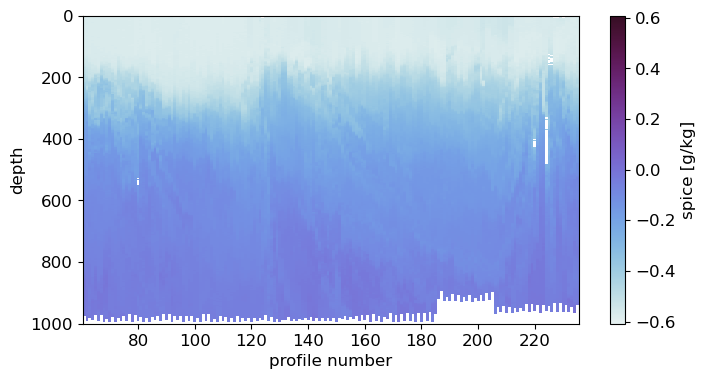

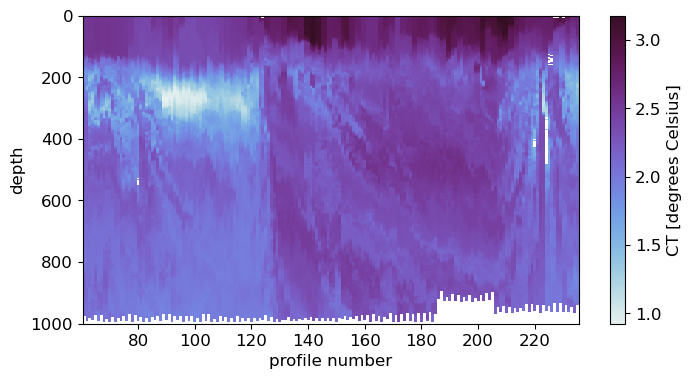

In [29]:
# Use module function to plot quick check
# Notice tight relationship between conservative temperature and spice
# sg.plot_var?   # show function documentation
sg.plot_var(sg.trim(gp_659, 125, 140), 'spice')
sg.plot_var(sg.trim(gp_659, 125, 140), 'CT')

In [45]:
import importlib
importlib.reload(sg)

<module 'sogos_module' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/CourseCode/MLGEO2022_sangsong/ml-sogos/scripts/sogos_module.py'>

In [19]:
# Prepare dataset for prediction by turning into a 2D Dataframe
df_659=sg.flatten2DF(gp_659)
df_660=sg.flatten2DF(gp_660)

lvar = ['Yearday', 'Julian Day', 'Latitude', 'Longitude', 'Pressure', 'SA', 'CT', 'Oxygen', 'Spice', 'Sigma 0', 'N_Squared_v2', 'Nprof', 'Depth', 'Dive']
df_659 = df_659[lvar]
df_660 = df_660[lvar]

In [20]:
df_659.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Spice,Sigma 0,N_Squared_v2,Nprof,Depth,Dive
3648,119.583289,2019-04-30 13:59:56.205999872,-51.495300,30.047100,4.035,33.988998,3.509,294.040501,-0.528216,26.904773,-6.526437e-06,0,4,2
4560,119.583318,2019-04-30 13:59:58.707000064,-51.495300,30.047100,5.044,33.987999,3.508,294.041848,-0.529028,26.904077,-4.999368e-06,0,5,2
5472,119.583376,2019-04-30 14:00:03.707000064,-51.495201,30.047199,6.053,33.987999,3.510,294.073202,-0.528816,26.903886,3.170546e-06,0,6,2
6384,119.583405,2019-04-30 14:00:06.206500096,-51.495201,30.047199,7.062,33.988998,3.511,294.612299,-0.528004,26.904582,2.857285e-06,0,7,2
7296,119.583434,2019-04-30 14:00:08.706000128,-51.495201,30.047199,8.070,33.988998,3.512,294.831964,-0.527898,26.904486,-4.583818e-07,0,8,2


In [21]:
# save glider DataFrames to run prediction on, runtime ~20 s
df_659.to_csv(var_path + 'Glider659_DF_1202.csv')
df_660.to_csv(var_path + 'Glider660_DF_1202.csv')

# ARCHIVE: save below code for main overview notebook

## Example to modify in sogos_overview 

In [ ]:
# Random Forest Model

ntrees = 1000
Mdl = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)
variable = 'pH'

if variable == "pH":
    #all
    # Create X Variables for each subset of data.
    X_training = training[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
    X_validation = validation[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
    X_test = test[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()

    Y_training = training[variable].to_numpy()
    Y_validation = validation[variable].to_numpy()
    Y_test = test[variable].to_numpy()
    

# Fit the model to the training subset of data
Mdl.fit(X_training, Y_training)

In [ ]:
# Predict Y (pH) in each subset of data (test at the end of development)
Y_pred_training = Mdl.predict(X_training)
Y_pred_validation = Mdl.predict(X_validation)
Y_pred_test = Mdl.predict(X_test)

# Create Error Metrics 
AE_RF_training = Y_pred_training - Y_training
IQR_RF_training = iqr(abs(AE_RF_training))

AE_RF_validation = Y_pred_validation - Y_validation
IQR_RF_validation = iqr(abs(AE_RF_validation))

AE_RF_test = Y_pred_test - Y_test
IQR_RF_test = iqr(abs(AE_RF_test))

RF_dict = {}
RF_dict["Model"] = ["Training", "Validation"]
RF_dict["Median Absolute Error"] = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation))]
RF_dict["IQR"] = [IQR_RF_training, IQR_RF_validation]
RF_DF = pd.DataFrame.from_dict(RF_dict)
RF_DF